In [1]:
import os, sys
import numpy as np
import pandas as pd
# use float_precision='round_trip' in pd.read_csv to make sure you're reading the actual number in the csv, without any pandas rounding
import scipy.integrate
from scipy.integrate import cumtrapz
from scipy.integrate import dblquad
from pathlib import Path
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import bisect
from scipy.optimize import curve_fit


In [2]:
path = 'data/'

# ################ constants & data import ################

# constants
g_A = 1.27 # [unitless] axial form factor
################
R_odot = 8.5 # [kpc] Sun's distance from centre of MW, from Clemens 1985
rho_s = 0.51 # [GeV/cm^3] DM radial scale for MW NFW profile; https://arxiv.org/abs/1906.08419
r_s = 8.1 # [kpc] DM radial scale for MW NFW profile; https://arxiv.org/abs/1906.08419; also used as distance scale for creating unitless quantities

R_max = 50.0 # [kpc]
################
energyScale = 10 # [MeV] energy scale for creating unitless quantities

# importing C12 and O16 data: excitation energies [MeV] and GT strengths [unitless]
C12_data = 'C12_dEs_GTs.txt'
O16_data = 'O16_dEs_GTs.txt'
C12df = pd.read_csv(C12_data, sep='\t', names=['dE [MeV]', 'GT'], skiprows=1, float_precision='round_trip')
O16df = pd.read_csv(O16_data, sep='\t', names=['dE [MeV]', 'GT'], skiprows=1, float_precision='round_trip')

# nuclear info dictionary
nuc_dict = {'C12': {'mass [MeV]': 11274.78, 'mass [unitless]': 11274.78/energyScale, 'spin': 0.0, 'dEs [MeV]': C12df['dE [MeV]'], 'GTs': C12df['GT']}, \
            'O16': {'mass [MeV]': 15033.04, 'mass [unitless]': 15033.04/energyScale, 'spin': 0.0, 'dEs [MeV]': O16df['dE [MeV]'], 'GTs': O16df['GT']}}
# 'He4': {'mass_MeV': 3758.26, 'mass [unitless]': 3758.26/energyScale, 'spin': 0.0}
# 'N14': {'mass_MeV': 13153.91, 'mass [unitless]': 13153.91/energyScale, 'spin': 0.0}

max_dict = {'C12': 33, 'O16': 38}


# integrating over angular variables

In [3]:
def integrate_over_b(m_chi, nucleus, dE, l):
    """
    returns: [cm^-2 s^-1 MeV^-1 rad^-1] differential flux dPhi/dEdl integrated over galactic latitude b
    ****************
    
    ****************
    """
    filename = path + '{}/dE_{}MeV/m_chi_{}MeV/l_{}deg.txt'.format(nucleus, dE, m_chi, l)

    # import differential flux data:
    diff_flux_data = pd.read_csv(filename, sep='\t', names = ['b [deg]', 'Differential flux [cm^-2 s^-1 MeV^-1 sr^-1]'], \
                                 comment = '#', float_precision='round_trip')
    
    diff_flux = diff_flux_data['Differential flux [cm^-2 s^-1 MeV^-1 sr^-1]'] # [cm^-2 s^-1 MeV^-1 sr^-1]
    bees = diff_flux_data['b [deg]'] # [deg], from -5.0 to 5.0
    # return bees

    # integrate over degrees using array of b's from -5.0 to 5.0:
    # test = np.linspace(-90,90,181)
    # integral = cumtrapz(np.sin(test * np.pi/180 + np.pi/2), test, initial=0) # testing to make sure output is as expected
    integral = cumtrapz(np.sin(bees * np.pi/180 + np.pi/2) * diff_flux, bees, initial=0) # [deg] * [cm^-2 s^-1 MeV^-1 sr^-1]
    # shift b by + np.pi/2 so that it has the proper azimuthal range from 0 to 180, since in GALPROP b goes from -89.5 to 89.5
    return integral[-1] * np.pi/180 # [cm^-2 s^-1 MeV^-1 rad^-1]; multiplied by np.pi/180 to get [deg] -> [rad]

# integrate_over_b(9.842704376866553, 'C12', 9.845321000000006, 330.0)
# integrate_over_b(25.657069658718825, 'O16', nuc_dict['O16']['dEs [MeV]'][29], 330.0)


In [4]:
def integrate_over_l(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, \
                     b_min, b_max, delta_b, l_min1, l_max1, l_min2, l_max2, delta_l, \
                     overwrite_b_integral_data):
    """
    calculates differential flux dPhi/dE integrated over galactic longitude l in two integrals:
    1. from l_min1 to l_max1 in steps of delta_l
    2. from l_min2 to l_max2 in steps of delta_l
    also writes to file the differential flux d^2Phi/dEdl integrated over galactic latitude b for each value of l
    ****************
    returns: ([cm^-2 s^-1 MeV^-1], [cm^-2 s^-1 MeV^-1]) 
             flux integrated over galactic latitude b, and over two regions of 
             galactic longitude l from [l_min1, l_max1] and [l_min2, l_max2]
    ****************
    
    """
    bInt = []

    def f(l): # l: [deg]
        integrand = integrate_over_b(m_chi, nucleus, dE, l) # [cm^-2 s^-1 MeV^-1 rad^-1]
        bInt.append(integrand) # [cm^-2 s^-1 MeV^-1 rad^-1]
        return integrand

    # integrated over degrees:
    ells1 = np.arange(l_min1, l_max1 + delta_l, delta_l)
    g1 = list(map(lambda ell1: f(ell1), ells1))
    integral1 = cumtrapz(g1, ells1, initial=0) # [cm^-2 s^-1 MeV^-1 rad^-1] * [deg]

    ells2 = np.arange(l_min2, l_max2 + delta_l, delta_l)
    g2 = list(map(lambda ell2: f(ell2), ells2))
    integral2 = cumtrapz(g2, ells2, initial=0) # [cm^-2 s^-1 MeV^-1 rad^-1] * [deg]

    #### write differential flux (integrated over b) to file for each value of l ####
    filename = path + '{}/dE_{}MeV/m_chi_{}MeV/m_chi_{}MeV_diff_flux_integrated_over_b.txt'.format(nucleus, dE, m_chi, m_chi)
    if not overwrite_b_integral_data:
        if os.path.isfile(filename):
            # print("    **** b integral data has already been written for dE = {} MeV, m_chi = {} MeV. File will not be overwritten.".format(dE, m_chi))
            return (integral1[-1] * np.pi/180, integral2[-1] * np.pi/180) # ([cm^-2 s^-1 MeV^-1 rad^-1] * [deg] * [rad/deg], [cm^-2 s^-1 MeV^-1 rad^-1] * [deg] * [rad/deg])

    metadata = "# Differential flux integrated over galactic latitude b.\n\
# m_chi [MeV] = {}\n\
# nucleus = {}\n\
# m_n [MeV] = {}\n\
# J_n = {}\n\
# dE [MeV] = {}\n\
# GT = {}\n\
# \n\
# g_chi [MeV^-1] = {}\n\
# g_A = {}\n\
# \n\
# galactic latitude bounds [deg]: [{}, {}]\n\
# galactic latitude bins [deg]: {}\n\
# \n\
# R_odot [kpc] = {}\n\
# R_max [kpc] = {}\n\
# rho_s [GeV cm^-3] = {}\n\
# r_s [kpc] = {}\n#\n".format(m_chi, nucleus, m_n, J_n, dE, GT, g_chi, g_A, b_min, b_max, delta_b, R_odot, R_max, rho_s, r_s)
    # print(metadata)
    with open(filename, 'w') as fp:
        fp.write(metadata)
    dat = {'# l [deg]': [*ells1, *ells2], 'Differential flux integrated over b [cm^-2 s^-1 MeV^-1 rad^-1]': bInt}
    df = pd.DataFrame(dat)
    df.to_csv(filename, sep='\t', index=False, mode='a')
    ################

    return (integral1[-1] * np.pi/180, integral2[-1] * np.pi/180) 
    # ([cm^-2 s^-1 MeV^-1 rad^-1] * [deg] * [rad/deg], [cm^-2 s^-1 MeV^-1 rad^-1] * [deg] * [rad/deg])
    # = ([cm^-2 s^-1 MeV^-1], [cm^-2 s^-1 MeV^-1])

# integrate_over_l(g_chi = 1, m_chi = 9.842704376866553, \
#                  nucleus = 'C12', m_n = nuc_dict['C12']['mass [MeV]'], J_n = nuc_dict['C12']['spin'], \
#                  dE = nuc_dict['C12']['dEs [MeV]'][0], GT = nuc_dict['C12']['GTs'][0], \
#                  b_min = -5, b_max = 5, delta_b = 0.25, \
#                  l_min1 = 330, l_max1 = 359.0, l_min2 = 0.5, l_max2 = 30.0, delta_l = 0.25, \
#                  overwrite_b_integral_data = True)
# integrate_over_l(g_chi = 1, m_chi = 25.657069658718825, \
#                          nucleus = 'O16', m_n = nuc_dict['O16']['mass [MeV]'], J_n = nuc_dict['O16']['spin'], \
#                          dE = nuc_dict['O16']['dEs [MeV]'][29], GT = nuc_dict['O16']['GTs'][29], \
#                          b_min = -5, b_max = 5, delta_b = 0.25, \
#                          l_min1 = 330, l_max1 = 359.0, l_min2 = 0.5, l_max2 = 30.0, delta_l = 0.25, \
#                          overwrite_b_integral_data = False)
# integrate_over_l(g_chi = 1, m_chi = 26.415772437998495, \
#                  nucleus = 'C12', m_n = nuc_dict['C12']['mass [MeV]'], J_n = nuc_dict['C12']['spin'], \
#                  dE = 26.416083000000008, GT = nuc_dict['C12']['GTs'][0], \
#                  b_min = -5, b_max = 5, delta_b = 0.25, \
#                  l_min1 = 330, l_max1 = 359.0, l_min2 = 0.5, l_max2 = 30.0, delta_l = 0.25, \
#                  overwrite_b_integral_data = False)

In [5]:
def average_over_solid_angle(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, \
                             b_min, b_max, delta_b, l_min1, l_max1, l_min2, l_max2, delta_l, \
                             integratedSolidAngle, \
                             overwrite_b_integral_data, overwrite_l_integral_data):
    """
    calculates and writes to file the differential flux integrated and averaged over the specified solid angle range
    ****************
    returns:    averaged flux [cm^-2 s^-1 MeV^-1 sr^-1]
                integrated flux [cm^-2 s^-1 MeV^-1]
                integrated flux from first l integral (l_min1 to l_max1) [cm^-2 s^-1 MeV^-1]
                integrated flux from second l integral (l_min2 to l_max2) [cm^-2 s^-1 MeV^-1]
    """
    
    filename = path + '{}/dE_{}MeV/m_chi_{}MeV/m_chi_{}MeV_diff_flux_integrated_and_averaged_over_solid_angle.txt'.format(nucleus, dE, m_chi, m_chi)
    # if not overwrite_l_integral_data:
    #     if os.path.isfile(filename):
    #         print("    **** l integral data has already been written for dE = {} MeV, m_chi = {} MeV. File will not be overwritten.".format(dE, m_chi))
    #         return

    # print("    running m_chi = {} MeV".format(m_chi))
    integratedFlux1, integratedFlux2 = [], []
    integratedFlux = []    
    intFlux1, intFlux2 = integrate_over_l(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, b_min, b_max, delta_b, l_min1, l_max1, l_min2, l_max2, delta_l, overwrite_b_integral_data) # ([cm^-2 s^-1 MeV^-1], [cm^-2 s^-1 MeV^-1])
    integratedFlux = intFlux1 + intFlux2 # [cm^-2 s^-1 MeV^-1]
    
    #### calculate solid-angle-averaged-flux ####
    averagedFlux = integratedFlux / integratedSolidAngle # [cm^-2 s^-1 MeV^-1 sr^-1]
    ################

    #### write solid-angle-averaged flux to file ####
    # Path(path + "{}/dE_{}MeV/m_chi_{}MeV".format(nucleus, dE, m_chi)).mkdir(parents=True, exist_ok=True)
    # filename = path + '{}/dE_{}MeV/m_chi_{}MeV/m_chi_{}MeV_l_integral_data.txt'.format(nucleus, dE, m_chi, m_chi)
    metadata = "# Differential flux, integrated over galactic latitude b and galactic longitude l and averaged over solid angle (SA). \n\
# m_chi [MeV] = {}\n\
# nucleus = {}\n\
# m_n [MeV] = {}\n\
# J_n = {}\n\
# dE [MeV] = {}\n\
# GT = {}\n\
# \n\
# g_chi [MeV^-1] = {}\n\
# g_A = {}\n\
# \n\
# galactic latitude bounds [deg]: [{}, {}]\n\
# galactic latitude bins [deg]: {}\n\
# galactic longitude bounds [deg]: [{}, {}], [{}, {}]\n\
# galactic longitude bins [deg]: {}\n\
# solid angle integrated over the above bounds [sr]: {}\n\
# \n\
# R_odot [kpc] = {}\n\
# R_max [kpc] = {}\n\
# rho_s [GeV cm^-3] = {}\n\
# r_s [kpc] = {}\n#\n".format(m_chi, nucleus, m_n, J_n, dE, GT, g_chi, g_A, \
                              b_min, b_max, delta_b, l_min1, l_max1, l_min2, l_max2, delta_l, integratedSolidAngle, \
                              R_odot, R_max, rho_s, r_s)
    # print(metadata)
    with open(filename, 'w') as fp:
        fp.write(metadata)
    dat = {'# SA integrated & averaged diff. flux [cm^-2 s^-1 MeV^-1 sr^-1]': [averagedFlux], 'SA integrated diff. flux [cm^-2 s^-1 MeV^-1]': [integratedFlux], \
           '[{}, {}] deg integral [cm^-2 s^-1 MeV^-1]'.format(l_min1, l_max1): [intFlux1], '[{}, {}] deg integral [cm^-2 s^-1 MeV^-1]'.format(l_min2, l_max2): [intFlux2]}
    df = pd.DataFrame(dat)
    df.to_csv(filename, sep='\t', index=False, mode='a')
    
    ################
    
    return (averagedFlux, integratedFlux, intFlux1, intFlux2)

# solid_angle_averaged_from_file(9.845281165618374, 'C12', 9.845321000000006)
# average_over_solid_angle(g_chi = 1, m_chi = 9.842704376866553, \
#                          nucleus = 'C12', m_n = nuc_dict['C12']['mass [MeV]'], J_n = nuc_dict['C12']['spin'], \
#                          dE = nuc_dict['C12']['dEs [MeV]'][0], GT = nuc_dict['C12']['GTs'][0], \
#                          b_min = -5, b_max = 5, delta_b = 0.25, \
#                          l_min1 = 330, l_max1 = 359.0, l_min2 = 0.5, l_max2 = 30.0, delta_l = 0.25, \
#                          integratedSolidAngle = 0.1779750967372331, \
#                          overwrite_b_integral_data = False, overwrite_l_integral_data = True)
# average_over_solid_angle(g_chi = 1, m_chi = 25.657069658718825, \
#                          nucleus = 'O16', m_n = nuc_dict['O16']['mass [MeV]'], J_n = nuc_dict['O16']['spin'], \
#                          dE = nuc_dict['O16']['dEs [MeV]'][29], GT = nuc_dict['O16']['GTs'][29], \
#                          b_min = -5, b_max = 5, delta_b = 0.25, \
#                          l_min1 = 330, l_max1 = 359.0, l_min2 = 0.5, l_max2 = 30.0, delta_l = 0.25, \
#                          integratedSolidAngle = 0.1779750967372331, \
#                          overwrite_b_integral_data = False, overwrite_l_integral_data = False)


In [6]:
def write_integrated_data(nucleus, overwrite_b_integral_data, overwrite_l_integral_data):
    """
    writes integrated flux data to files:
        - differential flux integrated over galactic latitude b
        - solid-angle-averaged differential flux (i.e. differential flux integrated over galactic latitude b, galactic longitude l)
    """
    # bounds taken to match https://arxiv.org/abs/astro-ph/9811211
    l_min1, l_max1 = 330, 359 # [deg], [deg], [deg]; bounds for first galactic longitude integral
    l_min2, l_max2 = 0.5, 30 # [deg], [deg]; bounds for second galactic longitude integral
    delta_l = 0.25 # [deg] binning for galactic longitude integrals
    b_min, b_max, delta_b = -5, 5, 0.25 # [deg], [deg], [deg]; bounds and binning for galactic latitude integral
    
    g_chi = 1 # [MeV^-1]
    m_n, J_n = nuc_dict[nucleus]['mass [MeV]'], nuc_dict[nucleus]['spin']

    #### integrate solid angle, for calculating solid-angle-averaged flux ####
    def f(b, l):
        integrand = np.sin(b * np.pi/180 + np.pi/2)
        return integrand # [unitless]
        
    integratedSolidAngle1 = dblquad(f, l_min1, l_max1, b_min, b_max)[0] * np.pi/180 * np.pi/180 # [sr]
    integratedSolidAngle2 = dblquad(f, l_min2, l_max2, b_min, b_max)[0] * np.pi/180 * np.pi/180 # [sr]
    integratedSolidAngle = integratedSolidAngle1 + integratedSolidAngle2 # [sr]
    print("integrated solid angle (flux denominator): {} sr".format(integratedSolidAngle))
    ################
    
    problem_dEs = []
    for dE in nuc_dict[nucleus]['dEs [MeV]'][0:max_dict[nucleus]]:
        try:
            i = list(nuc_dict[nucleus]['dEs [MeV]']).index(dE)
            GT = nuc_dict[nucleus]['GTs'][i] # [unitless]
            print('i = {}:    dE = {} MeV, GT = {}'.format(i, dE, GT))

            if not os.path.isdir(path + '{}/dE_{}MeV'.format(nucleus, dE)):
                print(path + '{}/dE_{}MeV'.format(nucleus, dE))
                print("path does not exist!")
                return

            for m_chi_path in sorted(glob(path + '{}/dE_{}MeV/m_chi_*'.format(nucleus, dE))):
                # print(m_chi_path)
                m_chi_dir = m_chi_path.split('/')[-1]
                m_chi = m_chi_dir.split('_')[2][:-3]
                # print(m_chi)
                average_over_solid_angle(g_chi, m_chi, nucleus, m_n, J_n, dE, GT, \
                                         b_min, b_max, delta_b, l_min1, l_max1, l_min2, l_max2, delta_l, \
                                         integratedSolidAngle, \
                                         overwrite_b_integral_data, overwrite_l_integral_data)
        except: 
            problem_dEs.append(dE)
        
    print("done!")
    return problem_dEs

# write_integrated_data('C12', True, True)
# write_integrated_data('O16', True, True)
# /Users/arm5765/Desktop/git/DM-nucleus-inelastic-ID/data/C12/dE_26.416083000000004MeV

# reading in the solid angle averaged flux

In [7]:
def read_solid_angle_averaged_flux(m_chi, nucleus, dE):
    """
    returns: [cm^-2 s^-1 MeV^-1 sr^-1] solid-angle-averaged flux read from file
    ****************
    """
    # print(file)
    SA_avgd_flux_data = pd.read_csv(path + '{}/dE_{}MeV/m_chi_{}MeV/m_chi_{}MeV_diff_flux_integrated_and_averaged_over_solid_angle.txt'.format(nucleus, dE, m_chi, m_chi), \
                                    sep='\t', \
                                    names=['SA integrated & averaged diff. flux [cm^-2 s^-1 MeV^-1 sr^-1]', 'SA integrated diff. flux [cm^-2 s^-1 MeV^-1]', \
                                           '[330, 359] deg integral [cm^-2 s^-1 MeV^-1]', '[0.5, 30] deg integral [cm^-2 s^-1 MeV^-1]'], \
                                    comment = '#', float_precision='round_trip') 
    SA_avgd_flux = SA_avgd_flux_data['SA integrated & averaged diff. flux [cm^-2 s^-1 MeV^-1 sr^-1]']
    return SA_avgd_flux.values[0] # [cm^-2 s^-1 MeV^-1 sr^-1]

read_solid_angle_averaged_flux(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0])


6630884347.844192

# Gaussian convolution

In [10]:
def R(dE, E, epsilon):
    """
    returns: [MeV^-1] gaussian convolution function with mean dE and variance (epsilon * dE)
    ****************
    dE: [MeV] nuclear deexcitation energy
    E: [MeV] observed photon energy
    epsilon: [unitless; percentage as a fraction of 1, i.e. epsilon = 0.05 for 5%]
    """
    expTerm = np.exp(-(E - dE)**2 / (2 * epsilon**2 * dE**2)) # [unitless]
    return (np.sqrt(2 * np.pi) * epsilon * dE)**(-1) * expTerm # [MeV^-1]

## CONVOLUTION:

Write differential flux as:
$$\frac{d^2\Phi}{dE_\gamma d\Omega} \equiv F \times \delta(\Delta E - E_\gamma) $$
where $F$ is the numerical factor calculated by TACC; including the delta function, the units are: cm$^{-2}$ s$^{-1}$ MeV$^{-1}$ sr$^{-1}$

Units of $F$: cm$^{-2}$ s$^{-1}$ sr$^{-1}$

Multiply by Gaussian $\rightarrow$ units: cm$^{-2}$ s$^{-1}$ MeV$^{-2}$ sr$^{-1}$.

Convolve by integrating $\rightarrow$ units: cm$^{-2}$ s$^{-1}$ MeV$^{-1}$ sr$^{-1}$:
$$ \begin{align} 
\int dE_\gamma~\frac{d^2\Phi}{dE_\gamma d\Omega} R_\epsilon(E - E_\gamma) &= F \int dE_\gamma~\delta(\Delta E - E_\gamma) ~R_\epsilon(E - E_\gamma) \\
&= F \times R_\epsilon(E - E_\gamma) \Bigg|_{E_\gamma \rightarrow \Delta E} \\
&= F \times \frac{1}{\sqrt{2\pi \epsilon^2 (\Delta E)^2}} \exp \left[ -\frac{(E - \Delta E)^2}{2 \epsilon^2 (\Delta E)^2} \right]
\end{align}$$

## Multiply by $E^2$ and integrate over observed energy $E$:

$$ F \times \int dE ~ E^2 \times \frac{1}{\sqrt{2\pi \epsilon^2 (\Delta E)^2}} \exp \left[ -\frac{(E - \Delta E)^2}{2 \epsilon^2 (\Delta E)^2} \right] $$

Units before integrating: cm$^{-2}$ s$^{-1}$ MeV$^{-1}$ sr$^{-1}$

Units after integrating: MeV MeV$^2$ cm$^{-2}$ s$^{-1}$ MeV$^{-1}$ sr$^{-1} = $ cm$^{-2}$ s$^{-1}$ MeV$^{2}$ sr$^{-1}$

This integral has an analytic result.

In [11]:
def integrate_E_sq_times_gaussian(epsilon, E_gamma, E):
    """
    returns: analytical result for integration of E^2 * Gaussian wrt observed energy E
    """
    int_E_sq_times_gauss = 1/np.sqrt(2 * np.pi * epsilon**2 * E_gamma**2) * \
    (1/2) * E_gamma**2 * epsilon * (-2 * epsilon * (E_gamma + E) * np.exp(-(E - E_gamma)**2 / (2 * epsilon**2 * E_gamma**2)) \
                                    - np.sqrt(2*np.pi) * E_gamma * (1+epsilon**2) * scipy.special.erf((E_gamma - E)/(np.sqrt(2) * E_gamma * epsilon)))
    return int_E_sq_times_gauss # [MeV^2]

# integrate_E_sq_times_gaussian(0.07, 10, 12) # checked with wolframalpha and mathematica; see gaussian_integration.nb


For deriving current constraints from existing COMPTEL data, we want to use COMPTEL binning: 3-10 MeV and 10-30 MeV:

3-10 MeV:
$$ F \times \int_3^{10} dE ~ E^2 \times \frac{1}{\sqrt{2\pi \epsilon^2 (\Delta E)^2}} \exp \left[ -\frac{(E - \Delta E)^2}{2 \epsilon^2 (\Delta E)^2} \right] $$

10-30 MeV:
$$ F \times \int_{10}^{30} dE ~ E^2 \times \frac{1}{\sqrt{2\pi \epsilon^2 (\Delta E)^2}} \exp \left[ -\frac{(E - \Delta E)^2}{2 \epsilon^2 (\Delta E)^2} \right] $$

Units after integrating: cm$^{-2}$ s$^{-1}$ MeV$^{2}$ sr$^{-1}$

In [12]:
def integrate_convolved_data_comptel_bins(m_chi, nucleus, dE, epsilon):
    """
    USED FOR CURRENT CONSTRAINTS FROM COMPTEL DATA
    calculates: theoretical SA averaged flux * analytically integrated (E^2 times convolution gaussian) over relevant energy bin: [3,10] or [10,30] MeV
    returns: area under E^2 times intensity curve
    """
    SA_avgd_flux = read_solid_angle_averaged_flux(m_chi, nucleus, dE) # [cm^-2 s^-1 MeV^-1 sr^-1]

    # integrate over relevant COMPTEL bin:
    # there are no energies that fall in the 1-3 MeV bin
    if dE>3 and dE<10:
        a = integrate_E_sq_times_gaussian(epsilon, dE, 3) # [MeV^2] * [MeV] from gaussian convolution
        b = integrate_E_sq_times_gaussian(epsilon, dE, 10) # [MeV^2] * [MeV] from gaussian convolution
        area = SA_avgd_flux * (b - a) # [cm^-2 s^-1 MeV^2 sr^-1]
    elif dE>10 and dE<30:
        a = integrate_E_sq_times_gaussian(epsilon, dE, 10) # [MeV^2] * [MeV] from gaussian convolution
        b = integrate_E_sq_times_gaussian(epsilon, dE, 30) # [MeV^2] * [MeV] from gaussian convolution
        area = SA_avgd_flux * (b - a) # [cm^-2 s^-1 MeV^2 sr^-1]

    return area # [cm^-2 s^-1 MeV^2 sr^-1]
    
integrate_convolved_data_comptel_bins(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon=0.01)


603959562643.522

In [13]:
def integrate_convolved_data_optimized_binning(m_chi, nucleus, dE, epsilon):
    """
    USED FOR FUTURE PROJECTIONS
    returns: theoretical SA averaged flux * analytically integrated (E^2 times convolution gaussian) over energy bins E-epsilonE, E+epsilonE
    """
    SA_avgd_flux = read_solid_angle_averaged_flux(m_chi, nucleus, dE) # [cm^-2 s^-1 MeV^-1 sr^-1]
    
    a = integrate_E_sq_times_gaussian(epsilon, dE, dE - dE*epsilon) # [MeV^2] * [MeV] from gaussian convolution
    b = integrate_E_sq_times_gaussian(epsilon, dE, dE + dE*epsilon) # [MeV^2] * [MeV] from gaussian convolution
    integrated_E_sq_times_intensity = SA_avgd_flux * (b-a) # [cm^-2 s^-1 MeV^2 sr^-1]
    
    # return [integrated_E_sq_times_intensity_1_3, integrated_E_sq_times_intensity_3_10, integrated_E_sq_times_intensity_10_30]
    return integrated_E_sq_times_intensity # [cm^-2 s^-1 MeV^2 sr^-1]

integrate_convolved_data_optimized_binning(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon = 0.01)


438800461780.06464

In [14]:
# sanity check to make sure the binned data integral is larger than the optimized binning:
binned = integrate_convolved_data_comptel_bins(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon=0.01)
optimized = integrate_convolved_data_optimized_binning(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon = 0.01)

print(binned/optimized > 1)


True


# some testing functions, not used for anything else

In [15]:
def write_convolution_data(nucleus, epsilon, overwrite_conv_data):
    """
    THIS FUNCTION IS ONLY USED FOR TESTING
    ****************
    writes convolution data for N energies from (dE - epsilon*dE) to (dE + epsilon*dE)
    this discrete data is then integrated and returned by the function:
        integrate_discrete_convolved_data(m_chi, nucleus, dE, epsilon)
    for comparison to the output of function:
        integrate_convolved_data_optimized_binning(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon = 0.01)
    """
    N = 51 # number of observed photon energies
    
    g_chi = 1 # [MeV^-1]
    m_n, J_n = nuc_dict[nucleus]['mass [MeV]'], nuc_dict[nucleus]['spin'] # [unitless, in units of energyScale], [unitless]

    l_min1, l_max1 = 330, 359 # [deg], [deg], [deg]; bounds for first galactic longitude integral
    l_min2, l_max2 = 0.5, 30 # [deg], [deg]; bounds for second galactic longitude integral
    delta_l = 0.25 # [deg] binning for galactic longitude integrals
    b_min, b_max, delta_b = -5, 5, 0.25 # [deg], [deg], [deg]; bounds and binning for galactic latitude integral

    #### integrate solid angle, for calculating solid-angle-averaged flux ####
    def f(b, l):
        integrand = np.sin(b * np.pi/180 + np.pi/2)
        return integrand # [unitless]
        
    integratedSolidAngle1 = dblquad(f, l_min1, l_max1, b_min, b_max)[0] * np.pi/180 * np.pi/180 # [sr]
    integratedSolidAngle2 = dblquad(f, l_min2, l_max2, b_min, b_max)[0] * np.pi/180 * np.pi/180 # [sr]
    integratedSolidAngle = integratedSolidAngle1 + integratedSolidAngle2 # [sr]
    print("integrated solid angle (flux denominator): {} sr".format(integratedSolidAngle))
    ################
    
    for dE in nuc_dict[nucleus]['dEs [MeV]'][0:max_dict[nucleus]]:
        obs_photon_energies = np.linspace((dE - 1 * epsilon * dE), (dE + 1 * epsilon * dE), N)
        i = list(nuc_dict[nucleus]['dEs [MeV]']).index(dE)
        GT = nuc_dict[nucleus]['GTs'][i] # [unitless]
        # print('i = {}:    dE = {} MeV, GT = {}'.format(i, dE, GT))
        if not os.path.isdir(path + '{}/dE_{}MeV'.format(nucleus, dE)):
            print(path + '{}/dE_{}MeV'.format(nucleus, dE))
            print("path does not exist!")
            return

        for m_chi_path in glob(path + '{}/dE_{}MeV/m_chi_*'.format(nucleus, dE)):
            m_chi_dir = m_chi_path.split('/')[-1]
            m_chi = m_chi_dir.split('_')[2][:-3]
            # print(m_chi)
            SA_avgd_flux = read_solid_angle_averaged_flux(m_chi, nucleus, dE)
            conv = [R(dE, E, epsilon) * SA_avgd_flux for E in obs_photon_energies]
        
            filename = path + '{}/dE_{}MeV/m_chi_{}MeV/m_chi_{}MeV_convolved_epsilon_{}.txt'.format(nucleus, dE, m_chi, m_chi, epsilon*100)
            if not overwrite_conv_data:
                if os.path.isfile(filename):
                    # print("    **** convolution data has already been written for dE = {} MeV, m_chi = {} MeV. File will not be overwritten.".format(dE, m_chi))
                    continue
                    
            metadata = "# Differential flux, integrated and averaged over solid angle (SA), multiplied by Gaussian with variance sigma = epsilon * dE. \n\
# m_chi [MeV] = {}\n\
# nucleus = {}\n\
# m_n [MeV] = {}\n\
# J_n = {}\n\
# dE [MeV] = {}\n\
# GT = {}\n\
# \n\
# g_chi [MeV^-1] = {}\n\
# g_A = {}\n\
# \n\
# galactic latitude bounds [deg]: [{}, {}]\n\
# galactic latitude bins [deg]: {}\n\
# galactic longitude bounds [deg]: [{}, {}], [{}, {}]\n\
# galactic longitude bins [deg]: {}\n\
# solid angle integrated over the above bounds [sr]: {}\n\
# \n\
# solid angle averaged flux [cm^-2 s^-1 MeV^-1 sr^-1]: {}\n\
# \n\
# R_odot [kpc] = {}\n\
# R_max [kpc] = {}\n\
# rho_s [GeV cm^-3] = {}\n\
# r_s [kpc] = {}\n\
# \n\
# energy resolution epsilon: {}\n\
# observed photon energy range [MeV]: [dE - 1 * epsilon * dE, dE + 1 * epsilon * dE]\n#\n".format(m_chi, nucleus, m_n, J_n, dE, GT, g_chi, g_A, \
                                                                                                  b_min, b_max, delta_b, l_min1, l_max1, l_min2, l_max2, delta_l, \
                                                                                                  integratedSolidAngle, SA_avgd_flux, \
                                                                                                  R_odot, R_max, rho_s, r_s, epsilon)
            # print(metadata)
            # return
            with open(filename, 'w') as fp:
                fp.write(metadata)
            dat = {'# Observed photon energy [MeV]': obs_photon_energies, 'Gaussian * SA averaged diff. flux [cm^-2 s^-1 MeV^-1 sr^-1]': conv}
            df = pd.DataFrame(dat)
            df.to_csv(filename, sep='\t', index=False, mode='a')        
            ################
    print("done!")

# write_convolution_data('C12', 0.01, overwrite_conv_data = True)
# write_convolution_data('C12', 0.02, overwrite_conv_data = True)
# write_convolution_data('C12', 0.03, overwrite_conv_data = True)
# write_convolution_data('C12', 0.04, overwrite_conv_data = True)
# write_convolution_data('O16', 0.01, overwrite_conv_data = True)
# write_convolution_data('O16', 0.02, overwrite_conv_data = True)
# write_convolution_data('O16', 0.03, overwrite_conv_data = True)
# write_convolution_data('O16', 0.04, overwrite_conv_data = True)


## integrate discrete data

In [16]:
def integrate_discrete_convolved_data(m_chi, nucleus, dE, epsilon):
    """
    THIS FUNCTION IS ONLY USED FOR TESTING
    ****************
    integrates the discrete convolution data written to file by function
        write_convolution_data(nucleus, epsilon, overwrite_conv_data)
    for comparison to the output of function
        integrate_convolved_data_optimized_binning(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon = 0.01)
    """
    convolved_diff_flux_data = pd.read_csv(path + '{}/dE_{}MeV/m_chi_{}MeV/m_chi_{}MeV_convolved_epsilon_{}.txt'.format(nucleus, dE, m_chi, m_chi, epsilon*100), \
                                    sep='\t', \
                                    names=['Observed photon energy [MeV]', 'Convolved SA averaged diff. flux [cm^-2 s^-1 MeV^-1 sr^-1]'], \
                                    comment = '#', float_precision='round_trip')

    photon_energy = convolved_diff_flux_data['Observed photon energy [MeV]']
    convolved_diff_flux = convolved_diff_flux_data['Convolved SA averaged diff. flux [cm^-2 s^-1 MeV^-1 sr^-1]']
    
    # calculate E^2 times convolved flux for comparison to COMPTEL:
    E_sq_times_intensity = [E**2 * f for E, f in zip(photon_energy, convolved_diff_flux)] # [cm^-2 s^-1 sr^-1 MeV^2]
    # return(E_sq_times_intensity)

    # integrated E^2 * intensity over observed photon energy:
    integral = cumtrapz(E_sq_times_intensity, photon_energy, initial=0) # [cm^-2 s^-1 sr^-1 MeV^2] * [MeV]
    return integral[-1]

integrate_discrete_convolved_data(m_chi = 9.842704376866553, \
                                  nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], \
                                  epsilon = 0.01)


438758990971.5903

In [17]:
# SANITY CHECK: these numbers should be close to one another; one is an analytic integral, the other is numerically integrated over discrete energies
integrate_convolved_data_optimized_binning(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon = 0.01)
# integrate_discrete_convolved_data(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon = 0.01)

438800461780.06464

# COMPTEL data from https://arxiv.org/abs/astro-ph/9811211

## COMPTEL data points

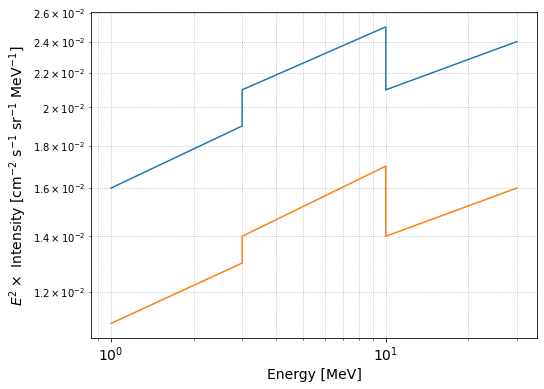

In [18]:
# COMPTEL, see https://arxiv.org/abs/astro-ph/9811211
comptel_dict_upper = {'E [MeV]': [1, 3, 3, 10, 10, 30], 
                    'E^2 * intensity [MeV cm^-2 s^-1 sr^-1]': [1.6e-2, 1.9e-2, 2.1e-2, 2.5e-2, 2.1e-2, 2.4e-2]}
comptel_interp_upper = interp1d(comptel_dict_upper['E [MeV]'], comptel_dict_upper['E^2 * intensity [MeV cm^-2 s^-1 sr^-1]'], fill_value='extrapolate')

comptel_dict_lower = {'E [MeV]': [1, 3, 3, 10, 10, 30], 
                       'E^2 * intensity [MeV cm^-2 s^-1 sr^-1]': [1.1e-2, 1.3e-2, 1.4e-2, 1.7e-2, 1.4e-2, 1.6e-2]}
comptel_interp_lower = interp1d(comptel_dict_lower['E [MeV]'], comptel_dict_lower['E^2 * intensity [MeV cm^-2 s^-1 sr^-1]'], fill_value='extrapolate')

fig, ax = plt.subplots(figsize = (8.0, 6.0))
plt.grid(which = 'both', linestyle = 'dotted')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Energy [MeV]', fontsize = 14)
plt.ylabel(r'$E^2 \times$ Intensity [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ MeV$^{-1}$]', fontsize = 14)
plt.plot(comptel_dict_upper['E [MeV]'], comptel_dict_upper['E^2 * intensity [MeV cm^-2 s^-1 sr^-1]'])
plt.plot(comptel_dict_lower['E [MeV]'], comptel_dict_lower['E^2 * intensity [MeV cm^-2 s^-1 sr^-1]'])


## trying various functional fits to COMPTEL data, to estimate future data

POWER FUNCTION FIT
The value of A is 0.01183 with standard error of 0.00092, which is 7.75559659913792%.
The value of B is 0.10263 with standard error of 0.03482, which is 33.92611467719238%.
The magnitude of the standard error % is 34.80130077595617%

POLY FIT
The value of A is -0.00001 with standard error of 0.00001, which is -56.84953189027904%.
The value of B is 0.00058 with standard error of 0.00026, which is 45.4438346875091%.
The value of C is 0.01129 with standard error of 0.00126, which is 11.11837658143575%.
The magnitude of the standard error % is 73.62492570492773%

LOG FIT
lower
The value of A is 1.5e-03 with standard error of 0.00047, which is 31.120629825083107%
The value of B is 1.2e-02 with standard error of 0.00095, which is 8.190412342059984%.
The magnitude of the standard error % is 32.180373755486755%

upper
The value of A is 2.4e-03 with standard error of 0.00067, which is 28.186857305937096%
The value of B is 1.7e-02 with standard error of 0.00136, which is 8.010

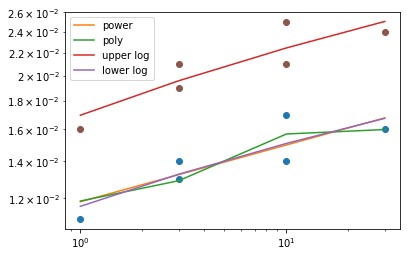

In [19]:
x_lower, y_lower = comptel_dict_lower['E [MeV]'], comptel_dict_lower['E^2 * intensity [MeV cm^-2 s^-1 sr^-1]']
x_upper, y_upper = comptel_dict_upper['E [MeV]'], comptel_dict_upper['E^2 * intensity [MeV cm^-2 s^-1 sr^-1]']
# convert to arrays
x_lower, y_lower = np.asarray(x_lower), np.asarray(y_lower)
x_upper, y_upper = np.asarray(x_upper), np.asarray(y_upper)
# plt.plot(x_lower, y_lower, 'o')

plt.xscale('log')
plt.yscale('log')
plt.plot(x_lower, y_lower, 'o')

################

def comptel_power_function(x, A, B):
    y = A * x**B
    return y

parameters, covariance = curve_fit(comptel_power_function, x_lower, y_lower)
fit_A = parameters[0]
fit_B = parameters[1]
# print(fit_A)
# print(fit_B)

SE = np.sqrt(np.diag(covariance))
SE_A, SE_B = SE[0], SE[1]

print('POWER FUNCTION FIT')
print(F'The value of A is {fit_A:.5f} with standard error of {SE_A:.5f}, which is {SE_A/fit_A * 100}%.')
print(F'The value of B is {fit_B:.5f} with standard error of {SE_B:.5f}, which is {SE_B/fit_B * 100}%.')
print('The magnitude of the standard error % is {}%\n'.format(np.sqrt((SE_A/fit_A * 100)**2 + (SE_B/fit_B * 100)**2)))

fit_y = comptel_power_function(x_lower, fit_A, fit_B)
# plt.plot(x_lower, y_lower, 'o', label='data')
plt.plot(x_lower, fit_y, '-', label='power')

################

def comptel_poly_function(x, A, B, C):
    y = A * x**2 + B * x + C
    return y

parameters, covariance = curve_fit(comptel_poly_function, x_lower, y_lower)
fit_A, fit_B, fit_C = parameters[0], parameters[1], parameters[2]
# print(fit_A)# print(fit_B)# print(fit_C)

SE = np.sqrt(np.diag(covariance))
SE_A = SE[0]
SE_B = SE[1]
SE_C = SE[2]

print('POLY FIT')
print(F'The value of A is {fit_A:.5f} with standard error of {SE_A:.5f}, which is {SE_A/fit_A * 100}%.')
print(F'The value of B is {fit_B:.5f} with standard error of {SE_B:.5f}, which is {SE_B/fit_B * 100}%.')
print(F'The value of C is {fit_C:.5f} with standard error of {SE_C:.5f}, which is {SE_C/fit_C * 100}%.')
print('The magnitude of the standard error % is {}%\n'.format(np.sqrt((SE_A/fit_A * 100)**2 + (SE_B/fit_B * 100)**2 + (SE_C/fit_C * 100)**2)))

fit_y = comptel_poly_function(x_lower, fit_A, fit_B, fit_C)
# plt.plot(x_lower, y_lower, 'o', label='data')
plt.plot(x_lower, fit_y, '-', label='poly')

################

def comptel_log_function(x, A, B):
    y = A * np.log(x) + B
    return y

# FITTING LOWER LINE OF COMPTEL DATA
parameters_lower, covariance_lower = curve_fit(comptel_log_function, x_lower, y_lower)
fit_A_lower, fit_B_lower = parameters_lower[0], parameters_lower[1]
# print(fit_A)# print(fit_B)
parameters_upper, covariance_upper = curve_fit(comptel_log_function, x_upper, y_upper)
fit_A_upper, fit_B_upper = parameters_upper[0], parameters_upper[1]
# print(fit_A)# print(fit_B)

SE_lower = np.sqrt(np.diag(covariance_lower))
SE_A_lower, SE_B_lower = SE_lower[0], SE_lower[1]
SE_upper = np.sqrt(np.diag(covariance_upper))
SE_A_upper, SE_B_upper = SE_upper[0], SE_upper[1]

print('LOG FIT')
print('lower')
print(F'The value of A is {fit_A_lower:.1e} with standard error of {SE_A_lower:.5f}, which is {SE_A_lower/fit_A_lower * 100}%')
print(F'The value of B is {fit_B_lower:.1e} with standard error of {SE_B_lower:.5f}, which is {SE_B_lower/fit_B_lower * 100}%.')
print('The magnitude of the standard error % is {}%\n'.format(np.sqrt((SE_A_lower/fit_A_lower * 100)**2 + (SE_B_lower/fit_B_lower * 100)**2)))
print('upper')
print(F'The value of A is {fit_A_upper:.1e} with standard error of {SE_A_upper:.5f}, which is {SE_A_upper/fit_A_upper * 100}%')
print(F'The value of B is {fit_B_upper:.1e} with standard error of {SE_B_upper:.5f}, which is {SE_B_upper/fit_B_upper * 100}%.')
print('The magnitude of the standard error % is {}%\n'.format(np.sqrt((SE_A_upper/fit_A_upper * 100)**2 + (SE_B_upper/fit_B_upper * 100)**2)))

fit_y_lower = comptel_log_function(x_lower, fit_A_lower, fit_B_lower)
fit_y_upper = comptel_log_function(x_upper, fit_A_upper, fit_B_upper)
plt.plot(x_upper, fit_y_upper, '-', label='upper log')
plt.plot(x_lower, fit_y_lower, '-', label='lower log')
plt.plot(x_upper, y_upper, 'o')
plt.legend()


## linear fit to log data

The COMPTEL log10-log10 plot has linear fit, therefore
$$ log_{10}(y) = m~log_{10}(x) + b $$
$$ Y = mX + b, $$

which means the actual fit to the data is
$$ y = 10^b x^m. $$

Integrating to get the total area,
$$ \begin{align}
\int_a^b y(x) ~dx &= 10^b \int_a^b x^m ~dx \\
&= \frac{10^b}{m+1} x^{m+1} \Bigg|_a^b
\end{align}
$$

$$ \therefore \textrm{Area under curve} = \frac{10^b}{m+1} x^{m+1} \Bigg|_a^b $$
where $(a, b) = (1, 3), (3, 10), (10, 30) ~\textrm{MeV}$.

Note that none of the de-excitation energies fall in the 1-3 MeV bin, so it is not needed, but I include the fit below.

In [21]:
# linear fit, from Excel (see extractedData-NEW.xlsx)
# LOWER LINES
slope_1_3_lower, intcpt_1_3_lower = 0.152, -1.959
slope_3_10_lower, intcpt_3_10_lower = 0.161, -1.931
slope_10_30_lower, intcpt_10_30_lower = 0.122, -1.975

# UPPER LINES
slope_1_3_upper, intcpt_1_3_upper = 0.156, -1.796
slope_3_10_upper, intcpt_3_10_upper = 0.145, -1.747
slope_10_30_upper, intcpt_10_30_upper = 0.122, -1.799


In [22]:
def test_loglog_fit(x, m, b):
    # test x = 1, 3, 10, 30 MeV for lower/upper limits to ensure they give the expected y-values
    return 10**b * x**m

# test_loglog_fit(1, slope_1_3_lower, intcpt_1_3_lower)
# test_loglog_fit(1, slope_1_3_upper, intcpt_1_3_upper)
test_loglog_fit(3, slope_1_3_lower, intcpt_1_3_lower)
# test_loglog_fit(3, slope_1_3_upper, intcpt_1_3_upper)
# test_loglog_fit(3, slope_3_10_lower, intcpt_3_10_lower)
# test_loglog_fit(3, slope_3_10_upper, intcpt_3_10_upper)
# test_loglog_fit(10, slope_3_10_lower, intcpt_3_10_lower)
# test_loglog_fit(10, slope_3_10_upper, intcpt_3_10_upper)
# test_loglog_fit(10, slope_10_30_lower, intcpt_10_30_lower)
# test_loglog_fit(10, slope_10_30_upper, intcpt_10_30_upper)
# test_loglog_fit(30, slope_10_30_lower, intcpt_10_30_lower)
# test_loglog_fit(30, slope_10_30_upper, intcpt_10_30_upper)


0.012987406402788637

# current constraints from COMPTEL bins

In [23]:
def integrate_comptel_bins(m_chi, nucleus, dE):
    """
    USED FOR DERIVING CURRENT COMPTEL LIMITS
    calculates the area under a single COMPTEL data bin, to be used in deriving current COMPTEL limits
    ****************
    returns: the area under the relevant [3,10] OR [10,30] MeV COMPTEL data bin, for upper and lower error bars
    ****************
    """
    def f(x1, x2, m, b):
        """
        returns the integral for the COMPTEL bin line from x1 to x2 with slope m and intercept b
        """
        f1 = ((10**b) / (m + 1)) * x1**(m+1)
        f2 = ((10**b) / (m + 1)) * x2**(m+1)
        return f2-f1

    # find which bin:
    if dE>3 and dE<10:
        area_under_lower = f(3, 10, slope_3_10_lower, intcpt_3_10_lower)
        area_under_upper = f(3, 10, slope_3_10_upper, intcpt_3_10_upper)
    elif dE>10 and dE<30:
        area_under_lower = f(10, 30, slope_10_30_lower, intcpt_10_30_lower)
        area_under_upper = f(10, 30, slope_10_30_upper, intcpt_10_30_upper)
    # elif dE>1 and dE<3:
    #     area_under_lower = f(1, 3, slope_1_3_lower, intcpt_1_3_lower)
    #     area_under_upper = f(1, 3, slope_1_3_upper, intcpt_1_3_upper)        

    return [area_under_lower, area_under_upper]
integrate_comptel_bins(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0])


[0.11012444486380055, 0.16335359092426566]

## testing: finding the ratio (upper bin area)/(lower bin area)

In our limits plot, the COMPTEL limit bar is approximately the same size as the projection limit bars.
This means the ratio of the upper bin area to the lower bin area should be the same as the ratio of the upper area and lower area for the region(dE +/- epsilon*dE)


In [34]:
# ratio of areas:
area_test_3_10 = integrate_comptel_bins(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0])

area_test_3_10[1]/area_test_3_10[0]

1.4833545006859987

In [35]:
integrate_comptel_bins(m_chi = 16.42578130366392, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][3])

[0.30385341983934927, 0.4556843659486083]

In [36]:
# ratio of areas:
area_test_10_30 = integrate_comptel_bins(m_chi = 16.42578130366392, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][1])

area_test_10_30[1]/area_test_10_30[0]

1.499684835502374

# projections for AMEGO-X, e-ASTROGAM, GRAMS

$$ \int (A \log(x) + B) ~dx = x(A\log(x) - A + B)$$

In [40]:
def integrate_comptel_log_fit(m_chi, nucleus, dE, epsilon):
    """
    USED FOR CALCULATING PROJECTIONS USING COMPTEL DATA
    calculates the area under the fitted COMPTEL data curve from
    dE-epsilon*dE to dE+epsilon*dE,
    to be used in deriving projections
    ****************
    returns: the area under the fitted COMPTEL data curve [dE-epsilon*dE, dE+epsilon*dE], for upper and lower error bars
    ****************    
    """
    # from log fit to COMPTEL data:
    A_lower, B_lower = 1.5e-3, 1.2e-2
    A_upper, B_upper = 2.4e-3, 1.7e-2

    def f(x1, x2, A, B):
        f1 = x1*(A*np.log(x1) - A + B)
        f2 = x2*(A*np.log(x2) - A + B)
        return f2 - f1

    area_under_lower = f(dE - epsilon*dE, dE + epsilon*dE, A_lower, B_lower) # [cm^-2 MeV^2 s^-1 sr^-1]
    area_under_upper = f(dE - epsilon*dE, dE + epsilon*dE, A_upper, B_upper) # [cm^-2 MeV^2 s^-1 sr^-1]

    ################
    # tests: 
    # return [f(3,10, A_lower, B_lower), f(3,10, A_upper, B_upper)]
    # should be close to (and probably less than, looking at the fit) integrate_comptel_bins(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0])
    # -> it is

    # return [f(10,30, A_lower, B_lower), f(10,30, A_upper, B_upper)]
    # should be close to (and probably more than, looking at the fit) integrate_comptel_bins(m_chi = 16.425643120657213, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][1])
    # -> it is
    ################
    
    return [area_under_lower, area_under_upper] # [ [cm^-2 MeV^2 s^-1 sr^-1],  [cm^-2 MeV^2 s^-1 sr^-1] ]

integrate_comptel_log_fit(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon = 0.01) 
# [0.0030383585031754645, 0.004428179481080763]
# integrate_comptel_log_fit(m_chi = 16.425643120657213, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][1], epsilon = 0.01)


[0.0030383585031754645, 0.004428179481080763]

## continuing testing of area ratios

In [44]:
# ratio of areas:
fit_area_test_3_10 = integrate_comptel_log_fit(m_chi = 9.842704376866553, nucleus = 'C12', \
                                               dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon = 0.02)

fit_area_test_3_10[1]/fit_area_test_3_10[0]

1.457424254109867

In [42]:
integrate_comptel_log_fit(m_chi = 16.42578130366392, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][1], epsilon = 0.01) 

[0.005322564267772334, 0.007793221152435803]

In [49]:
# ratio of areas:
fit_area_test_10_30 = integrate_comptel_log_fit(m_chi = 16.42578130366392, nucleus = 'C12', \
                                                dE = nuc_dict['C12']['dEs [MeV]'][1], epsilon = 0.01) 

fit_area_test_10_30[1]/fit_area_test_10_30[0]

1.4641854490368642

## therefore the fact that all the limit bars are the same size makes sense;

### COMPTEL BIN AREAS
from 3 to 10 MeV:
$$ \frac{\text{upper bin area}}{\text{lower bin area}} = 1.483 $$

from 10 to 30 MeV:
$$ \frac{\text{upper bin area}}{\text{lower bin area}} = 1.5 $$


### COMPTEL FUNCTION FIT AREA FROM $E_\gamma \pm \epsilon E_\gamma$
from 3 to 10 MeV:
$$ \frac{\text{upper bin area}}{\text{lower bin area}} = 1.457 $$

from 10 to 30 MeV:
$$ \frac{\text{upper bin area}}{\text{lower bin area}} = 1.464 $$


In [39]:
# integrate_comptel_bins(m_chi = 9.842704376866553, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0])
# integrate_comptel_bins(m_chi = 16.425643120657213, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][1])

In [73]:
def write_comptel_limits_on_g_chi(epsilon = 0.02):

    problem_dEs = []
    problem_dEs_index = []

    for nucleus in ['C12', 'O16']:
        print(nucleus)
        dE_g_chi_dict = {}
        dEs = nuc_dict[nucleus]['dEs [MeV]'][0:max_dict[nucleus]]
        m_chis_for_points, g_chis_lower_points, g_chis_upper_points = [], [], []
        
        for dE in dEs:
            print(dE)
            try:
                m_chis, g_chis_lower, g_chis_upper = [], [], []
                # m_chi_g_chi_dict = {}
            
                for m_chi_path in sorted(glob(path + '{}/dE_{}MeV/m_chi_*'.format(nucleus, dE))):
                    if not os.path.isdir(m_chi_path):
                        print(m_chi_path)
                        print("path does not exist!")
                        return
                    
                    m_chi_dir = m_chi_path.split('/')[-1]
                    m_chi = float(m_chi_dir.split('_')[2][:-3])
                    # print("    {} MeV".format(m_chi))
    
                    # calculate the area under E^2 x convolved differential flux, within the relevant COMPTEL energy bin 
                    theoretical_area_under_bin = integrate_convolved_data_comptel_bins(m_chi, nucleus, dE, epsilon)
                    if theoretical_area_under_bin == 0: # this will happen if the flux for this particular m_chi is zero, so just move to the next one
                        print("    mass {} MeV flux is zero".format(m_chi))
                        continue
        
                    m_chis.append(m_chi)
                    comptel_bin_area = integrate_comptel_bins(m_chi, nucleus, dE) # [total area under lower piecewise line, total area under upper piecewise line]
                    
                    # find the upper bound on the coupling constants for the upper and lower COMPTEL uncertainties
                    # they are UPPER limits because we are assuming all of the COMPTEL flux is due to this process; 
                    # g_chi needs to be smaller in order for the flux to comprise a smaller fraction of COMPTEL
                    g_chi_lower = np.sqrt(comptel_bin_area[0] / theoretical_area_under_bin)
                    g_chi_upper = np.sqrt(comptel_bin_area[1] / theoretical_area_under_bin)
                    g_chis_lower.append(g_chi_lower)
                    g_chis_upper.append(g_chi_upper)
                    # m_chi_g_chi_dict.update({m_chi: [g_chi_lower, g_chi_upper]})
            
            except:
                problem_dEs.append(dE)
                i = problem_dEs.index(dE)
                problem_dEs_index.append(i)

            filename = path + "{}/dE_{}MeV/COMPTEL_g_chi_limits_epsilon_{}.txt".format(nucleus, dE, 100*epsilon)
            # with open(filename, 'w') as fp:
                # fp.write(metadata)
            dat = {'# m_chi [MeV]': m_chis, 'g_chi lower uncertainty [MeV^-1]': g_chis_lower, 'g_chi upper uncertainty [MeV^-1]': g_chis_upper}
            df = pd.DataFrame(dat)
            df.to_csv(filename, sep='\t', index=False)#, mode='a')    

            if not m_chis[g_chis_lower.index(min(g_chis_lower))] == m_chis[g_chis_lower.index(min(g_chis_lower))]:
                print("m_chis are not the same!")

            g_chis_lower_points.append(min(g_chis_lower))
            g_chis_upper_points.append(min(g_chis_upper))
            m_chis_for_points.append(m_chis[g_chis_lower.index(min(g_chis_lower))])

        # write to file all the most constraining points, to be plotted
        filename = path + "{}/COMPTEL_g_chi_limits_epsilon_{}.txt".format(nucleus, 100*epsilon)
        filename2 = "g_chi_limits/{}/COMPTEL_g_chi_limits_epsilon_{}.txt".format(nucleus, 100*epsilon)
        dat = {'# dE [MeV]': dEs, 'most constraining m_chi [MeV]': m_chis_for_points, 'min g_chi lower uncertainty [MeV^-1]': g_chis_lower_points, 'min g_chi upper uncertainty [MeV^-1]': g_chis_upper_points}
        df = pd.DataFrame(dat)
        df.to_csv(filename, sep='\t', index=False)
        df.to_csv(filename2, sep='\t', index=False)

    return problem_dEs, problem_dEs_index # dE_g_chi_dict
    # return m_chi_g_chi_dict

# write_comptel_limits_on_g_chi()#, save = False)#True)


In [85]:
def write_projections_on_g_chi():
    epsilon_exp_dict = {0.01: 'GRAMS', 0.02: 'AMEGO-X', 0.03: 'e-ASTROGAM'}

    problem_dEs = []
    problem_dEs_index = []

    for nucleus in ['C12', 'O16']:
        print(nucleus)
        # m_chi_pts = []
        # g_lower_pts = []
        # g_upper_pts = []
        
        for epsilon in [0.01, 0.02, 0.03]:
            m_chis_for_points, g_chis_lower_points, g_chis_upper_points = [], [], []
            dEs = nuc_dict[nucleus]['dEs [MeV]'][0:max_dict[nucleus]]
            
            for dE in dEs:
                # print('    {}'.format(dE))
                try:
                    m_chis, g_chis_lower, g_chis_upper = [], [], []
                    # m_chi_g_chi_dict = {}
                
                    for m_chi_path in sorted(glob(path + '{}/dE_{}MeV/m_chi_*'.format(nucleus, dE))):
                        if not os.path.isdir(m_chi_path):
                            print(m_chi_path)
                            print("path does not exist!")
                            return
                        m_chi_dir = m_chi_path.split('/')[-1]
                        m_chi = float(m_chi_dir.split('_')[2][:-3])
                        # print(m_chi)
                        
                        theoretical = integrate_convolved_data_optimized_binning(m_chi, nucleus, dE, epsilon) # [cm^-2 MeV^2 s^-1 sr^-1]
                        if theoretical == 0:
                            # print("zero")
                            continue
                
                        m_chis.append(m_chi)
                        comptel_log_fit = integrate_comptel_log_fit(m_chi, nucleus, dE, epsilon) # [cm^-2 MeV^2 s^-1 sr^-1]
                        # print(comptel_log_fit)
                        
                        # find the upper bound on the coupling constants for the upper and lower COMPTEL uncertainties
                        # they are UPPER limits because we are assuming all of the COMPTEL flux is due to this process; 
                        # g_chi needs to be smaller in order for the flux to comprise a smaller fraction of COMPTEL
                        g_chi_lower = np.sqrt(comptel_log_fit[0] / theoretical)
                        g_chi_upper = np.sqrt(comptel_log_fit[1] / theoretical)
                        g_chis_lower.append(g_chi_lower)
                        g_chis_upper.append(g_chi_upper)
                        # m_chi_g_chi_dict.update({m_chi: [g_chi_lower, g_chi_upper]})
    
                    # m_chi_pts.append(m_chis[g_chis_lower.index(min(g_chis_lower))])
                    # g_lower_pts.append(min(g_chis_lower))
                    # g_upper_pts.append(min(g_chis_upper))

                except:
                    problem_dEs.append(dE)
                    # problem_dEs_index.append(dEs.index(dE))

                filename = path + "{}/dE_{}MeV/{}_g_chi_limits_epsilon_{}.txt".format(nucleus, dE, epsilon_exp_dict[epsilon], epsilon*100)
                # print(filename)
                # with open(filename, 'w') as fp:
                #     fp.write(metadata)
                dat = {'# m_chi [MeV]': m_chis, 'g_chi lower uncertainty [MeV^-1]': g_chis_lower, 'g_chi upper uncertainty [MeV^-1]': g_chis_upper}
                df = pd.DataFrame(dat)
                df.to_csv(filename, sep='\t', index=False)#, mode='a')
                
                if not m_chis[g_chis_lower.index(min(g_chis_lower))] == m_chis[g_chis_lower.index(min(g_chis_lower))]:
                    print("m_chis are not the same!")
    
                g_chis_lower_points.append(min(g_chis_lower))
                g_chis_upper_points.append(min(g_chis_upper))
                m_chis_for_points.append(m_chis[g_chis_lower.index(min(g_chis_lower))])
        
        # write to file all the minimum points to be plotted
            filename = path + "{}/{}_g_chi_limits_epsilon_{}.txt".format(nucleus, epsilon_exp_dict[epsilon], 100*epsilon)
            filename2 = "g_chi_limits/{}/{}_g_chi_limits_epsilon_{}.txt".format(nucleus, epsilon_exp_dict[epsilon], 100*epsilon)
            dat = {'# dE [MeV]': dEs, 'most constraining m_chi [MeV]': m_chis_for_points, 'min g_chi lower uncertainty [MeV^-1]': g_chis_lower_points, 'min g_chi upper uncertainty [MeV^-1]': g_chis_upper_points}
            df = pd.DataFrame(dat)
            df.to_csv(filename, sep='\t', index=False)
            df.to_csv(filename2, sep='\t', index=False)

    return #problem_dEs, problem_dEs_index #dE_g_chi_dict # m_chi_g_chi_dict

write_projections_on_g_chi()#True)


C12
O16


In [ ]:
integrate_convolved_data(m_chi = 9.837999999999996, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon = 0.01)

In [ ]:
integrate_comptel_log_fit(m_chi = 9.837999999999996, nucleus = 'C12', dE = nuc_dict['C12']['dEs [MeV]'][0], epsilon = 0.01)